
# Problem 6

In this notebook, we construct and evaluate a Bayesian multiple regression model using Stan, where we predict insurance charges from BMI, age, and number of children. After fitting the model to the training data and obtaining the posterior distributions for the parameters, we generate predictive samples for the test set. These samples are used to calculate the predictive means and the RMSE, assessing the model's accuracy.

In [37]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import stan
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()


## Data Loading and Preprocessing

To predict insurance charges with Bayesian multiple regression, we begin by loading the dataset and focusing on the relevant features: BMI, age, number of children, and charges. These features are then standardized to have a mean of zero and a standard deviation of one, ensuring that differences in scale do not bias our model's performance. Standardizing the data facilitates model convergence and makes the interpretation of parameter estimates more intuitive. After standardization, the data is divided into a training set, which will be used to fit our model, and a test set, which will be reserved for evaluating the model's predictive performance.

In [38]:
# Load the dataset
data = pd.read_csv('problem5/insurance.csv')

# Selecting relevant columns
data = data[['bmi', 'age', 'children', 'charges']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the predictors and the outcome variable
scaled_features = scaler.fit_transform(data.drop('charges', axis=1))  # Standardize features
scaled_charges = scaler.fit_transform(data['charges'].values.reshape(-1, 1)).flatten()  # Standardize charges

# Create a DataFrame for the scaled features
scaled_data = pd.DataFrame(scaled_features, columns=['bmi', 'age', 'children'])
scaled_data['charges'] = scaled_charges

# Split the data into training and test sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

## Bayesian Multiple Regression Model

The core of our Bayesian approach is the specification of the multiple regression model, which includes priors for the noise parameter (`sigma`), the intercept (`alpha`), and the regression coefficients (`beta`). The noise parameter follows an inverse-gamma distribution, reflecting our belief about the variability of insurance charges. The intercept and coefficients are drawn from normal and multivariate normal distributions, respectively. These priors are designed to express initial uncertainty in our estimates before observing the data.

In [39]:
vectorized_program_code = '''
data {
    int<lower=0> N; // Number of training data points
    int<lower=1> K; // Number of predictors
    matrix[N, K] x; // Matrix of predictors for training data
    vector[N] y;    // Outcome (insurance charges) for training data
    int<lower=0> N_new; // Number of test data points
    matrix[N_new, K] x_new; // Matrix of predictors for test data

    // Hyperparameters for priors
    real<lower=0> tau_0;
    real<lower=0> tau_1;
    real<lower=0> sigma_alpha;
    vector<lower=0>[K] sigma_beta;
}

parameters {
    real alpha;            // Intercept
    vector[K] beta;        // Coefficients for predictors
    real<lower=0> sigma2;  // Variance (sigma squared)
}

transformed parameters {
    real<lower=0> sigma;   // Standard deviation
    sigma = sqrt(sigma2);
}

model {
    // Priors with target +=
    target += inv_gamma_lpdf(sigma | tau_0, tau_1);
    target += normal_lpdf(alpha | 0, sigma_alpha);
    target += multi_normal_lpdf(beta | rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Vectorized Likelihood
    target += normal_lpdf(y | x * beta + rep_vector(alpha, N), sigma);
}

generated quantities {
    array[N_new] real y_pred_new; // Predicted charges for test data
    y_pred_new = normal_rng(rep_vector(alpha, N_new) + x_new * beta, rep_vector(sigma, N_new));
}
'''


## Model Fitting

With our model defined, we prepare the training data in the format expected by Stan, specifying the number of data points (N), the number of predictors (K), the standardized predictor matrix (x), and the standardized charges (y). The priors' hyperparameters are set to reasonable values based on the standardized data. We build and sample from the posterior using Stan's MCMC algorithm, yielding distributions for each parameter that encapsulate our updated beliefs after considering the data.

In [40]:
# Preparing data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': 3,
    'x': train_data[['bmi', 'age', 'children']].values,
    'y': train_data['charges'].values,
    'N_new': test_data.shape[0],
    'x_new': test_data[['bmi', 'age', 'children']].values,
    'tau_0': 0.01,
    'tau_1': 0.01,
    'sigma_alpha': 0.5,
    'sigma_beta': [0.5, 0.5, 0.5]
}

# Fitting the model
posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)
fit = posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: 12.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the fo

## RMSE

Calculate the Root-Mean-Squared Error (RMSE), which is achieved by comparing mean predictions against the actual observed values from the test dataset. This comparison quantifies the model's prediction accuracy. The RMSE value is output, providing a concise and informative metric of the model’s predictive performance on testing data.

In [41]:
# Extract samples from the predictive distribution
y_pred_samples = fit['y_pred_new']

# Calculate the mean of the predictive samples over all chains and samples
y_pred_mean = np.mean(y_pred_samples, axis=1)

# Get charges from the test data
y_true = test_data['charges'].values

# Calculate RMSE
rmse = np.sqrt(np.mean((y_true - y_pred_mean) ** 2))

print(f'RMSE: {rmse}')


RMSE: 0.9456633212463728


## Evaluation and Interpretation

In [42]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.047,0.059,0.000,0.000,9278.0,6192.0,1.0
beta[0],0.167,0.030,0.114,0.225,0.000,0.000,9308.0,5522.0,1.0
beta[1],0.255,0.029,0.204,0.311,0.000,0.000,9476.0,6737.0,1.0
beta[2],0.056,0.028,0.002,0.108,0.000,0.000,9280.0,5369.0,1.0
sigma2,0.882,0.039,0.812,0.957,0.000,0.000,9185.0,5718.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred_new[263],0.518,0.951,-1.212,2.379,0.011,0.008,8004.0,7108.0,1.0
y_pred_new[264],0.199,0.939,-1.570,1.950,0.010,0.008,8146.0,7689.0,1.0
y_pred_new[265],-0.102,0.928,-1.827,1.650,0.010,0.007,8106.0,7768.0,1.0
y_pred_new[266],0.701,0.956,-1.134,2.479,0.011,0.008,8046.0,7427.0,1.0


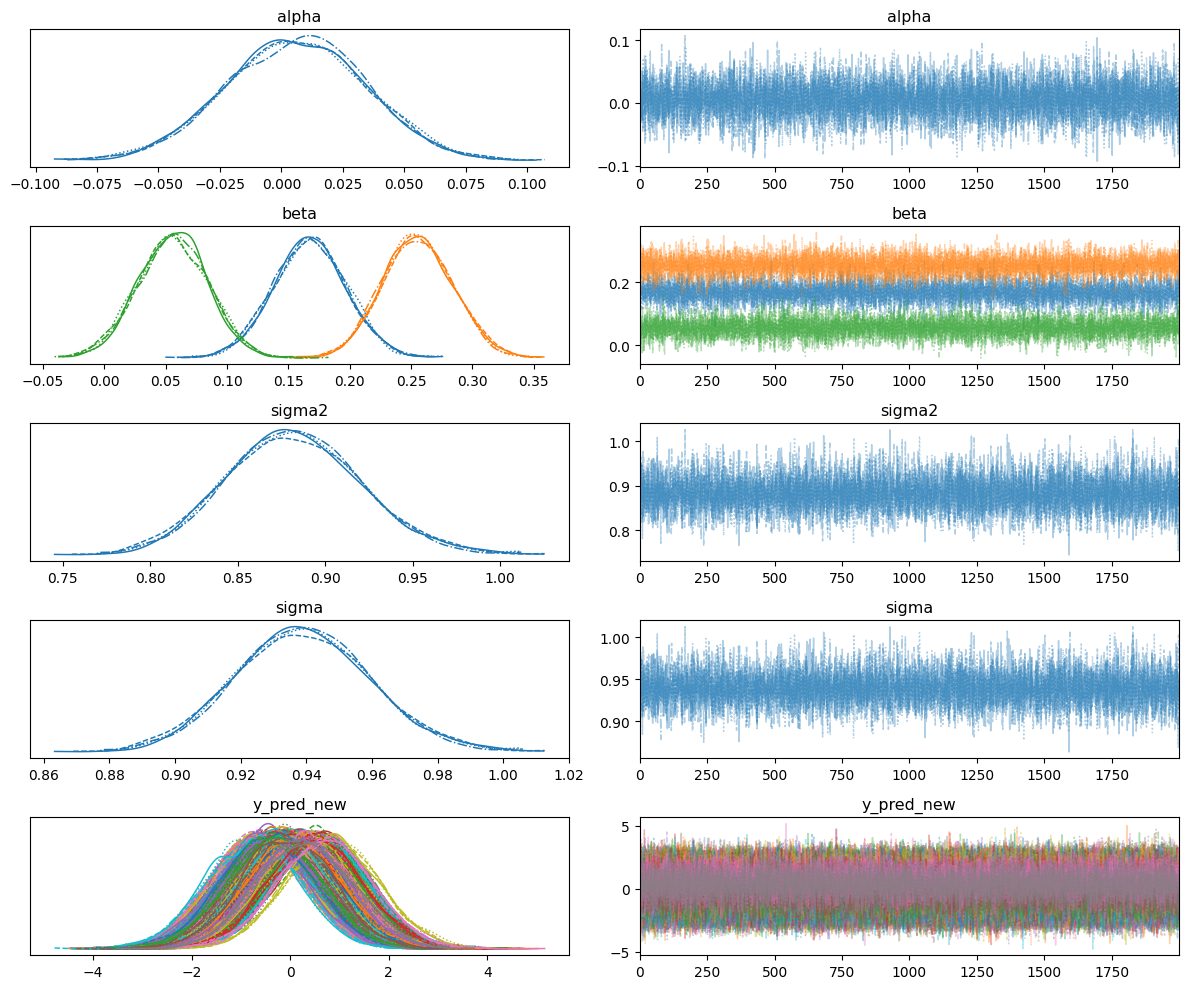

In [43]:
az.plot_trace(fit)
plt.tight_layout()

### How good are your predictions?

The RMSE value of 0.9457 indicates the average magnitude of the errors between the predicted values and the actual charges. Given that RMSE is in the same units as the predicted variable and lower values signify better performance, this model seems to have a moderate level of predictive accuracy.

### What information did you lose by computing the predictive means?
Computing predictive means simplifies the distribution of possible outcomes to a single point estimate. This process loses the uncertainty information in the predictive distribution, such as the variance and the shape of the distribution, which could indicate the probability of extreme outcomes or the confidence in the predictions. Essentially, the variability and confidence intervals around each predicted mean are not captured in the RMSE calculation.

### How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values?

To propagate the uncertainty encoded in the predictive distribution to a distribution over the test RMSE values, I would calculate RMSE for each posterior predictive sample set, not just the means. This will create a distribution of RMSE values that reflects the full uncertainty of the model's predictions.